## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 7.0 MB/s 
     |████████████████████████████████| 243 kB 74.4 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset('emotion')

In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [15]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)


In [ ]:
tokenizer.texts_to_sequences([tweets[1]])

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

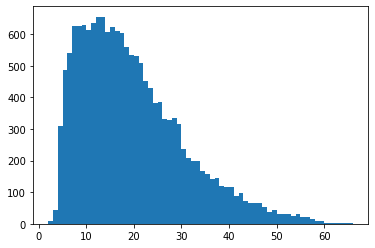

In [22]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [23]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [25]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [26]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [27]:
classes = set(labels)
print(classes)

{'sadness', 'fear', 'surprise', 'love', 'joy', 'anger'}


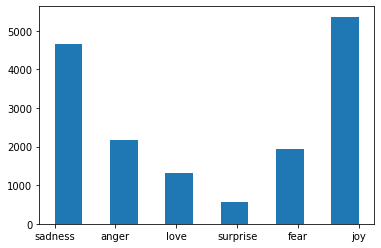

In [34]:
plt.hist(labels, bins = 11)
plt.show()

In [42]:
class_to_index = dict((c, i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k,v in class_to_index.items())

In [43]:
class_to_index

{'anger': 5, 'fear': 1, 'joy': 4, 'love': 3, 'sadness': 0, 'surprise': 2}

In [44]:
index_to_class

{0: 'sadness', 1: 'fear', 2: 'surprise', 3: 'love', 4: 'joy', 5: 'anger'}

In [45]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [46]:
train_labels = names_to_ids(labels)
print(train_labels[0:5])

[0 0 5 3 5]


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [48]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length= maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')              
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [50]:
val_tweets, val_labels = get_tweet(val)
val_seq =  get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [51]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [52]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)]
)

Epoch 1/20
500/500 [==============================] - 15s 16ms/step - loss: 1.3081 - accuracy: 0.4829 - val_loss: 0.7530 - val_accuracy: 0.7390
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4863 - accuracy: 0.8381 - val_loss: 0.4876 - val_accuracy: 0.8370
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2663 - accuracy: 0.9142 - val_loss: 0.4038 - val_accuracy: 0.8640
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1715 - accuracy: 0.9437 - val_loss: 0.3311 - val_accuracy: 0.8905
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1293 - accuracy: 0.9584 - val_loss: 0.3369 - val_accuracy: 0.8975
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1029 - accuracy: 0.9659 - val_loss: 0.3250 - val_accuracy: 0.8930
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0828 - accuracy: 0.9716 - val_loss: 0.3833 - val_accuracy: 0.889

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

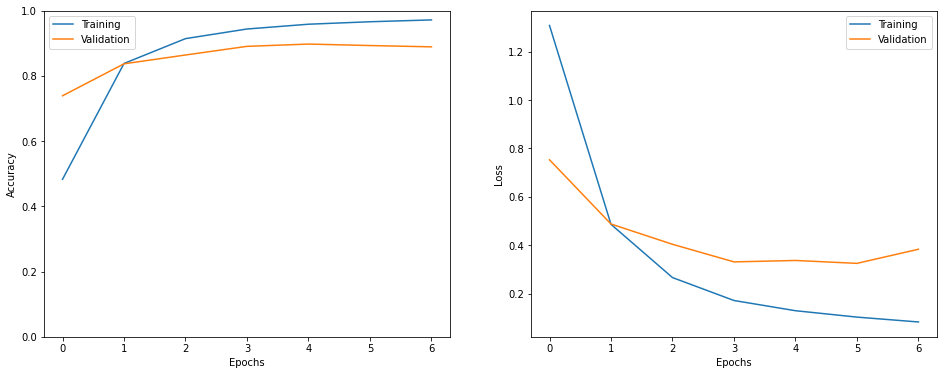

In [53]:
show_history(h)

In [54]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [55]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3974 - accuracy: 0.8800


In [60]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],axis = [0]))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i started feeling uncomfortable around my straight male friends particularly after one of them drunkenly came on to me grabbing at my waist while he attempted to murmur sweet nothings in my ear at a party that same week
Emotion: fear
Predicted Emotion: anger


In [66]:
preds = np.argmax(model.predict(test_seq),axis = -1)

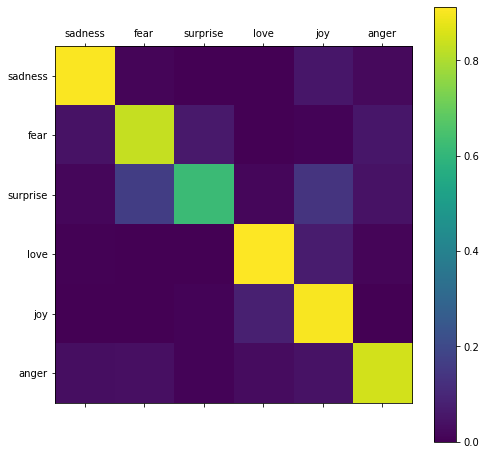

In [67]:
show_confusion_matrix(test_labels, preds, list(classes))